# Titanic Dataset Preprocessing


First of all let's import basic libraries to load, edit and visualize the dataset

In [43]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline


Now lets load the csv file for the training and test set.

In [44]:
training_set = pd.read_csv('train.csv')
test_set = pd.read_csv('test.csv')
training_set.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


Here we can see that we have many categorical features and some numeric ones too. Before turning this dataset into vectors of numbers that our classification algorithms can use, we should deal with missing values.
Let's check how many missing values has our dataset per feature.

In [45]:
training_set.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [46]:
test_set.isnull().sum()

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64

We could delete the training samples that have NaN values but in this case we dont have a huge dataset.
First we are going to transform the Cabin feature into a Deck feature, each cabin starts with a letter that denotes the deck and we dont really need more information than that.

In [47]:
# make a list of all the posible Decks, the last element is used when no cabin code is present
cabin_list = ['A', 'B', 'C', 'D', 'E', 'F', 'T', 'G', 'Unknown']
#define a function that replaces the cabin code with the deck character
def search_substring(big_string, substring_list):
    for substring in substring_list:
        if substring in big_string:
            return substring
    return substring_list[-1]

We have a similar problem with the Name feature, we have too much information that is hard to encode and nt useful. So we can take only the title of the name for each person, lets define a function for that.

In [48]:
# replace passenger's name with his/her title (Mr, Mrs, Miss, Master)
def get_title(string):
    import re
    regex = re.compile(r'Mr|Don|Major|Capt|Jonkheer|Rev|Col|Dr|Mrs|Countess|Dona|Mme|Ms|Miss|Mlle|Master', re.IGNORECASE)
    results = regex.search(string)
    if results != None:
        return(results.group().lower())
    else:
        return(str(np.nan))

In [49]:
# dictionary to map to generate the new feature vector
title_dictionary = {
    "capt":"Officer", 
    "col":"Officer", 
    "major":"Officer", 
    "dr":"Officer",
    "jonkheer":"Royalty",
    "rev":"Officer",
    "countess":"Royalty",
    "dona":"Royalty",
    "lady":"Royalty",
    "don":"Royalty",
    "mr":"Mr",
    "mme":"Mrs",
    "ms":"Mrs",
    "mrs":"Mrs",
    "miss":"Miss",
    "mlle":"Miss",
    "master":"Master",
    "nan":"Mr"
}

Now that we have the functions we need, lets apply them and create the features Title and Deck

In [50]:
training_set['Deck'] = training_set['Cabin'].map(lambda x: search_substring(str(x), cabin_list))
test_set['Deck'] = test_set['Cabin'].map(lambda x: search_substring(str(x), cabin_list))
# delete the Cabin feature
training_set.drop('Cabin', 1, inplace=True)
test_set.drop('Cabin', 1, inplace=True)

training_set['Title'] = training_set['Name'].apply(get_title)
test_set['Title'] = test_set['Name'].apply(get_title)
training_set['Title'] = training_set['Title'].map(title_dictionary)
test_set['Title'] = test_set['Title'].map(title_dictionary)
# delete the Name feature
training_set.drop('Name', 1, inplace=True)
test_set.drop('Name', 1, inplace=True)

Let's take a look at the results we got

In [51]:
training_set.tail()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,Deck,Title
886,887,0,2,male,27.0,0,0,211536,13.00,S,Unknown,Officer
887,888,1,1,female,19.0,0,0,112053,30.00,S,B,Miss
888,889,0,3,female,NaN,1,2,W./C. 6607,23.45,S,Unknown,Miss
889,890,1,1,male,26.0,0,0,111369,30.00,C,C,Mr
890,891,0,3,male,32.0,0,0,370376,7.75,Q,Unknown,Mr


Now we will drop the Ticket feature that does not really give much insight.

In [52]:
#dropping ticket column
training_set.drop('Ticket', 1, inplace=True)
test_set.drop('Ticket', 1, inplace=True)

We have to do something about the NaN values in the Age column. We can replace them with the mean of the age, but that would mean that some kid (Master or Miss) would appear to be older than they are. So we will take the mean of the age from each Title, and then replace each NaN value with the mean of the age of the corresponding persons title.

In [53]:
means_title = training_set.groupby('Title')['Age'].mean()

In [54]:
title_list = ['Mr','Miss','Mrs','Master', 'Royalty', 'Officer']
def age_nan_replace(means, dframe, title_list):
    for title in title_list:
        temp = dframe['Title'] == title #extract indices of samples with same title
        dframe.loc[temp, 'Age'] = dframe.loc[temp, 'Age'].fillna(means[title]) # replace nan values for mean
        

age_nan_replace(means_title, training_set, title_list)
age_nan_replace(means_title, test_set, title_list)

Now lets fill those two NaN cases in the Embarked column.

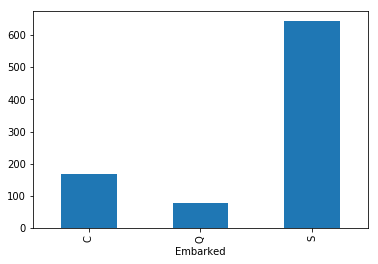

In [55]:
training_set.groupby('Embarked').size().plot(kind='bar')

We will assgn them the letter S which is the most common case.

In [56]:
training_set['Embarked'].fillna('S', inplace=True)
test_set['Embarked'].fillna('S', inplace=True)
#fill the fare column in the test set
test_set['Fare'].fillna(test_set['Fare'].mean(), inplace=True)

In [57]:
training_set.head()

,PassengerId,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked,Deck,Title
0,1,0,3,male,22.0,1,0,7.2500,S,Unknown,Mr
1,2,1,1,female,38.0,1,0,71.2833,C,C,Mr
2,3,1,3,female,26.0,0,0,7.9250,S,Unknown,Miss
3,4,1,1,female,35.0,1,0,53.1000,S,C,Mr
4,5,0,3,male,35.0,0,0,8.0500,S,Unknown,Mr


Let's visualize some aspects of the data so that we can understand what are the most important factors that determined survival.

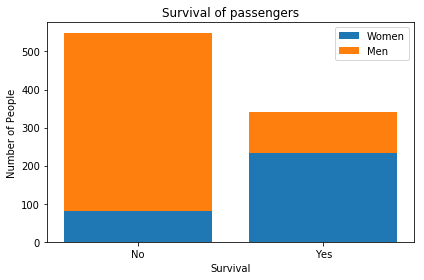

In [58]:
index = training_set['Survived'].unique() # get the number of bars
grouped_data = training_set.groupby(['Survived', 'Sex']) 
temp = grouped_data.size().unstack() 
women_stats = (temp.iat[0,0], temp.iat[1,0])
men_stats = (temp.iat[0,1], temp.iat[1,1])
p1 = plt.bar(index, women_stats)
p2 = plt.bar(index, men_stats, bottom=women_stats)
plt.xticks(index, ('No', 'Yes'))
plt.ylabel('Number of People')
plt.xlabel('Survival')
plt.title('Survival of passengers')
plt.legend((p1[0], p2[0]), ('Women', 'Men'))
plt.tight_layout()


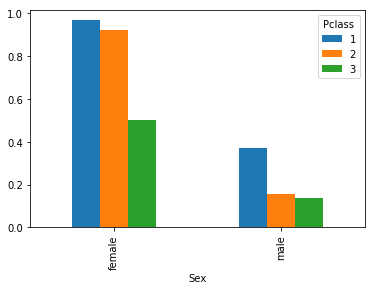

In [59]:
training_set.pivot_table('Survived',index='Sex',columns='Pclass').plot(kind='bar')


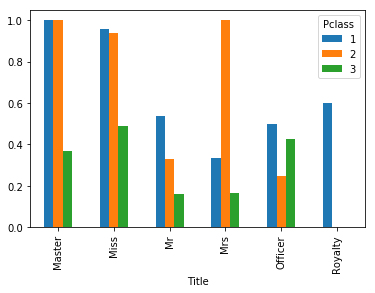

In [60]:
training_set.pivot_table('Survived', index='Title', columns='Pclass').plot(kind='bar')

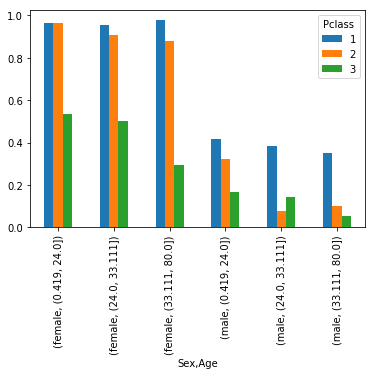

In [61]:
age_intervals = pd.qcut(training_set['Age'], 3)
training_set.pivot_table('Survived', ['Sex', age_intervals], 'Pclass').plot(kind='bar')

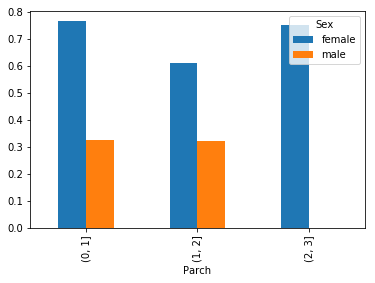

In [62]:
parch_intervals = pd.cut(training_set['Parch'], [0,1,2,3])
sibsp_intervals = pd.cut(training_set['SibSp'], [0,1,2,3])
training_set.pivot_table('Survived', parch_intervals, 'Sex').plot(kind='bar')

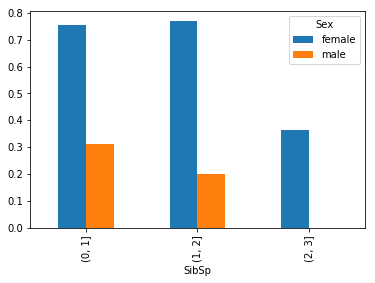

In [63]:
training_set.pivot_table('Survived', sibsp_intervals, 'Sex').plot(kind='bar')

What we can take from this analysis is that Passenger Class was relevant to survive, and that the features SibSp and Parch behave similarly. We can make a new feature called Family Size that is the sum of those 2 feature columns. 

In [64]:
training_set['Family Size'] = training_set['Parch'] + training_set['SibSp']
test_set['Family Size'] = test_set['Parch'] + test_set['SibSp']
training_set.drop('Parch', axis=1, inplace=True)
training_set.drop('SibSp', axis=1, inplace=True)
test_set.drop('Parch', axis=1, inplace=True)
test_set.drop('SibSp', axis=1, inplace=True)
training_set.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Deck,Title,Family Size
0,1,0,3,male,22.0,7.2500,S,Unknown,Mr,1
1,2,1,1,female,38.0,71.2833,C,C,Mr,1
2,3,1,3,female,26.0,7.9250,S,Unknown,Miss,0
3,4,1,1,female,35.0,53.1000,S,C,Mr,1
4,5,0,3,male,35.0,8.0500,S,Unknown,Mr,0


In [65]:
training_set.isnull().sum()


PassengerId    0
Survived       0
Pclass         0
Sex            0
Age            0
Fare           0
Embarked       0
Deck           0
Title          0
Family Size    0
dtype: int64

In [66]:
test_set.isnull().sum()

PassengerId    0
Pclass         0
Sex            0
Age            0
Fare           0
Embarked       0
Deck           0
Title          0
Family Size    0
dtype: int64

Let's standardize the numerical features Age and Fare

In [67]:
from sklearn.preprocessing import StandardScaler

numericals_list = ['Age','Fare']
for column in numericals_list:
    sc = StandardScaler(with_mean=True, with_std=True)
#    print(training_set[column].size)
#    print(test_set[column].size)
    sc.fit(training_set[column].values.reshape(-1,1))
    training_set[column] = sc.transform(training_set[column].values.reshape(-1,1))
    test_set[column] = sc.transform(test_set[column].values.reshape(-1,1))


Now let's encode categorical classes with sklearn's LabelEncoder

In [68]:
from sklearn.preprocessing import LabelEncoder
categorical_classes_list = ['Sex','Embarked','Deck', 'Title'] #Pclass is already encoded
#encode features that are cateorical classes
encoding_list = []
for column in categorical_classes_list:
    le = LabelEncoder()
    le.fit(training_set[column])
    encoding_list.append(training_set[column].unique())
    encoding_list.append(list(le.transform(training_set[column].unique())))
    training_set[column] = le.transform(training_set[column])
    test_set[column] = le.transform(test_set[column])

In [69]:
# lets see the results
training_set.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Deck,Title,Family Size
0,1,0,3,1,-0.587428,-0.502445,2,8,2,1
1,2,1,1,0,0.617618,0.786845,0,2,2,1
2,3,1,3,0,-0.286167,-0.488854,2,8,1,0
3,4,1,1,0,0.391672,0.420730,2,2,2,1
4,5,0,3,1,0.391672,-0.486337,2,8,2,0


Now we are going to onehot encode categorical features such as Embarked, Title and Pclass

In [70]:
'''training_set = pd.get_dummies(training_set, columns=['Embarked','Pclass','Title', 'Deck'])
test_set = pd.get_dummies(test_set, columns=['Embarked','Pclass','Title', 'Deck'])'''


"training_set = pd.get_dummies(training_set, columns=['Embarked','Pclass','Title', 'Deck'])\ntest_set = pd.get_dummies(test_set, columns=['Embarked','Pclass','Title', 'Deck'])"

In [71]:
training_set.head()

,PassengerId,Survived,Pclass,Sex,Age,Fare,Embarked,Deck,Title,Family Size
0,1,0,3,1,-0.587428,-0.502445,2,8,2,1
1,2,1,1,0,0.617618,0.786845,0,2,2,1
2,3,1,3,0,-0.286167,-0.488854,2,8,1,0
3,4,1,1,0,0.391672,0.420730,2,2,2,1
4,5,0,3,1,0.391672,-0.486337,2,8,2,0


In [72]:
test_set.head()

,PassengerId,Pclass,Sex,Age,Fare,Embarked,Deck,Title,Family Size
0,892,3,1,0.354014,-0.490783,1,8,2,0
1,893,3,0,1.295457,-0.507479,2,8,2,1
2,894,2,1,2.425187,-0.453367,1,8,2,0
3,895,3,1,-0.210851,-0.474005,2,8,2,0
4,896,3,0,-0.587428,-0.401017,2,8,2,2


The test set lacks a sample where deck 7 is selected so we will have to align the dataframes and to complete 

In [73]:
'''training_set, test_set = training_set.align(test_set, axis=1)
test_set.drop('Survived', axis=1, inplace=True)
test_set.head()'''

"training_set, test_set = training_set.align(test_set, axis=1)\ntest_set.drop('Survived', axis=1, inplace=True)\ntest_set.head()"

Now that we have our dataset clean and ready, we need to transform it into a numpy matrix that a learning algorithm can use.
We will get a Y vector containing the labels for training, a matrix X that has all the features for training, and X_test that has all the samples for training from the test set.

In [74]:
#test_set.fillna(0, inplace=True)
y = training_set['Survived'].values
X = training_set.drop(['Survived','PassengerId'], axis=1).values
X_test = test_set.drop('PassengerId', axis=1).values

In [75]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(criterion='entropy', random_state=0, n_estimators=5)
forest.fit(X,y)
#predictions = forest.predict(X_test)
print(forest.score(X,y))


0.965207631874


In [76]:
from sklearn.svm import SVC
svm = SVC(C=1, max_iter=1, kernel='rbf')
svm.fit(X,y)
#predictions = svm.predict(X_test)
print(svm.score(X,y))

0.540965207632


C:\Users\PC-ESCRITORIO\Anaconda3\lib\site-packages\sklearn\svm\base.py:218: ConvergenceWarning: Solver terminated early (max_iter=1).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


In [82]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0, C=0.1, max_iter=100, penalty='l1')
lr.fit(X, y)
print(lr.score(X, y))
predictions = lr.predict(X_test)

0.796857463524


In [83]:
submission_df = pd.DataFrame({'PassengerId': test_set.PassengerId, 'Survived': predictions})
submission_df.to_csv('submission.csv', index=False)